In [2]:
# coding: utf-8

import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube import Datacube
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from unsharp_mask import unsharp_mask

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling
import SpatialTools

# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')


def interpolate_timeseries(ds, freq='7D', method='linear'):
    
    """
    Interpolate new data between each existing xarray timestep at a given
    frequency. For example, `freq='7D'` will interpolate new values at weekly
    intervals from the start time of the xarray dataset to the end time. 
    `freq='24H'` will interpolate new values for each day, etc.
    
    :param ds:
        The xarray dataset to interpolate new time-step observations for.
        
    :param freq:
        An optional string giving the frequency at which to interpolate new time-step 
        observations. Defaults to '7D' which interpolates new values at weekly intervals; 
        for a full list of options refer to Panda's list of offset aliases: 
        https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
        
    :param method:
        An optional string giving the interpolation method to use to generate new time-steps.
        Default is 'linear'; options are {'linear', 'nearest'} for multidimensional arrays and
        {'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'} for 1-dimensional arrays.
        
    :return:
        A matching xarray dataset covering the same time period as `ds`, but with an 
        interpolated for each time-step given by `freq`.
        
    """    
    
    if isinstance(freq, str):
    
        # Use pandas to generate dates from start to end of ds at a given frequency
        start_time = ds.isel(time=0).time.values.item() 
        end_time = ds.isel(time=-1).time.values.item()    
        from_to = pd.date_range(start=start_time, end=end_time, freq=freq)

        # Use these dates to linearly interpolate new data for each new date
        print('Interpolating {} time-steps at {} intervals'.format(len(from_to), freq))
        return ds.interp(coords={'time': from_to}, method=method)
    
    elif isinstance(freq, int):
        
        # Get array of all timesteps
        ds_times = ds.time.values

        # Create list to save output
        interp_times_all = []

        # For each pair of timestamps, interpolate intermediate frames
        for i, value in enumerate(ds_times[:-1]):

            # Interpolate new dates between start and end dates
            interp_times = pd.date_range(start=value, end=ds_times[i+1], periods=(2 + freq))

            # Keep only new dates, not start and end dates
            interp_times_all.append(interp_times[1:-1].values)

        # Combine new dates with old dates and sort
        from_to = np.concatenate([*interp_times_all, ds_times])
        from_to.sort()
        
        # Use these dates to linearly interpolate new data for each new date
        print('Interpolating {} time-steps by generating {} intermediate frames'.format(len(from_to), freq))
        return ds.interp(coords={'time': from_to}, method=method)


def hsv_image_processing(rgb_array,
                         hue_mult=1, sat_mult=1.035, val_mult=1.035,
                         unsharp_radius1=20, unsharp_amount1=2.5, 
                         unsharp_radius2=1, unsharp_amount2=1.0):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask and take average
    a = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius1, amount=unsharp_amount1)
    b = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius2, amount=unsharp_amount2)
    hsv_array[:, :, 2] = np.mean(np.array([a, b]), axis=0)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))


In [11]:
#############################
# Set up analysis variables #
#############################

# # Channel country
# study_area = 'channelcountry'
# lat, lon, buffer_m = -25.63, 142.449760, 20000
# time_range = ('1986-06-01', '2018-12-01')
# resolution = (-50, 50)
# ratio = (1280/720.0)
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.98
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_clearprop = 0.8
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['swir1', 'nir', 'green']  # ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels=1200
# interval = 30
# rolling_median = 13
# interpolation_freq = '12D'
# power = 1.0
# image_proc_func = hsv_image_processing

# # Canberra
# study_area = 'canberra'
# lat, lon, buffer_m = -35.3082, 149.1244, 18000
# time_range = ('1986-06-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = (1280/720.0)
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.96
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.01, 0.99]
# width_pixels = 2560
# interval = 100
# rolling_median = 25
# interpolation_freq = None
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.3,
#                           unsharp_radius2=1, unsharp_amount2=0)

# # Gungahlin
# study_area = 'gungahlin'
# lat, lon, buffer_m = -35.191608, 149.132524, 7500
# time_range = ('1986-06-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = (1280/720.0)
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.96
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 2560
# interval = 80
# rolling_median = 31
# interpolation_freq = None
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# # Molonglo
# study_area = 'molonglo'
# lat, lon, buffer_m = -35.307688, 149.032756, 5500
# time_range = ('1999-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = (1280/720.0)
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.96
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 2560
# interval = 120
# rolling_median = 7
# interpolation_freq = None #'14D'
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# # Melbourne
# study_area = 'melbourne'
# lat, lon, buffer_m = -37.9067852366, 144.953384712, 38000
# time_range = ('2016-01-01', '2018-12-01')
# resolution = (-100, 100)
# ratio = 1.0
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.5
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.01, 0.99]
# width_pixels = 700
# interval = 100
# rolling_median = 50
# interpolation_freq = None
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.3,
#                           unsharp_radius2=1, unsharp_amount2=0)

# # Murray Mouth
# study_area = 'murraymouth'
# lat, lon, buffer_m = -35.555767, 138.881697, 10000
# time_range = ('1987-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.0
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.95
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.01, 0.99]
# width_pixels = 700
# interval = 100
# rolling_median = 3
# interpolation_freq = None
# power = 1.0
# image_proc_func = None

# # Stuart point
# study_area = 'stuart'
# lat, lon, buffer_m =-12.227, 131.8675, 3000
# time_range = ('1995-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.5
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.95
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = [ 'swir1', 'nir', 'green']  # ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 600
# interval = 25
# rolling_median = 24
# interpolation_freq = None
# power = 1.0
# image_proc_func = None

# # SouthStradbroke
# study_area = 'southstradbroke'
# lat, lon, buffer_m = -27.735275498104677, 153.44527244555763, 6500
# time_range = ('1987-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.0
# landsat_mask_dict = {'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.90
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.01, 0.99]
# width_pixels = 700
# interval = 70
# rolling_median = 17
# interpolation_freq = None
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.0, sat_mult=1.1, 
#                           unsharp_radius1=20, unsharp_amount1=1.2,
#                           unsharp_radius2=1, unsharp_amount2=0)


# study_area = 'mclarenvale'
# lat, lon, buffer_m = -35.224768512, 138.542068038, 13000
# time_range = ('1986-06-01', '2018-12-01')
# resolution = (-50, 50)
# ratio = 1.0  # (1280/720.0)
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.70
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls8']  # 'ls5', 'ls7', 
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 2560
# interval = 50
# rolling_median = 21
# interpolation_freq = '14D'
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# study_area = 'mtbarker'
# lat, lon, buffer_m = -35.0609078937, 138.865425388, 9000
# time_range = ('1987-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.0  # (1280/720.0)
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.6
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']   
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.001, 0.999]
# width_pixels = 720
# interval = 50
# rolling_median = 33
# interpolation_freq = 1  #None # '28D'
# power = 1.0
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# study_area = 'lakealbert'
# lat, lon, buffer_m = -35.6221419633, 139.279207077, 15000
# time_range = ('1987-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.0  # (1280/720.0)
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.85
# sentinel_clearprop = 0.7
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']   
# sentinel_sensors = ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 1200
# interval = 40
# rolling_median = 9
# interpolation_freq = 1  #None # '28D'
# power = 0.5
# image_proc_func = None

# study_area = 'lakeeyre'
# lat, lon, buffer_m = -28.6288284606, 137.272839793, 120000
# time_range = ('2018-05-01', '2018-12-01')
# resolution = (-250, 250)
# ratio = 1.0  # (1280/720.0)
# landsat_mask_dict = {'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.85
# sentinel_clearprop = 0.7
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']   
# sentinel_sensors = None #['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 1200
# interval = 40
# rolling_median = 9
# interpolation_freq = 1  #None # '28D'
# power = 0.5
# image_proc_func = None

# study_area = 'northernadelaide'
# lat, lon, buffer_m = -34.652, 138.607, 12000
# time_range = ('1987-01-01', '2018-12-01')
# resolution = (-25, 25)
# ratio = 1.5
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.70
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls8']  # 'ls5', 'ls7', 
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 2560
# interval = 50
# rolling_median = 21
# interpolation_freq = 1
# power = 0.5
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# study_area = 'walgett'
# lat, lon, buffer_m =  -30.0044, 148.1087, 3000
# time_range = ('2015-06-01', '2018-12-01')
# resolution = (-10, 10)
# ratio = 1.5
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 1.00
# sentinel_clearprop = 0.65
# landsat_product = 'nbart'
# landsat_sensors = None
# sentinel_sensors = ['s2a', 's2b']
# bands = ['red', 'green', 'blue', 'nir']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 800
# interval = 80
# rolling_median = 17
# interpolation_freq = 1
# power = 0.5
# image_proc_func = None

# study_area = 'walgett_false'
# lat, lon, buffer_m =  -30.0044, 148.1087, 6500
# time_range = ('2016-09-01', '2019-01-31')
# resolution = (-20, 20)
# ratio = 1.5
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 1.00
# sentinel_clearprop = 0.65
# landsat_product = 'nbart'
# landsat_sensors = None
# sentinel_sensors = ['s2a', 's2b']
# bands = ['swir2', 'nir', 'green']
# percentile_stretch = [0.01, 0.99]
# width_pixels = 800
# interval = 80
# rolling_median = 17
# interpolation_freq = 1
# power = 1.0
# image_proc_func = partial(hsv_image_processing, 
#                           sat_mult=1.0, val_mult=1.0,
#                           unsharp_radius1=20, unsharp_amount1=0.5,
#                           unsharp_radius2=1, unsharp_amount2=0.0)

# study_area = 'northernadelaide'
# lat, lon, buffer_m = -34.652, 138.607, 12000
# time_range = ('1987-01-01', '2019-02-01')
# resolution = (-25, 25)
# ratio = 1.5
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.70
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']   
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 1200
# interval = 50
# rolling_median = 21
# interpolation_freq = 1
# power = 0.5
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

# study_area = 'barossavalley'
# lat, lon, buffer_m = -34.5277565844, 138.960764792, 20000
# time_range = ('2016-01-01', '2019-02-01')
# resolution = (-50, 50)
# ratio = 1.5
# landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
# landsat_clearprop = 0.70
# sentinel_clearprop = 0.8
# landsat_product = 'nbart'
# landsat_sensors = ['ls5', 'ls7', 'ls8']   
# sentinel_sensors = None  # ['s2a', 's2b']
# bands = ['red', 'green', 'blue']
# percentile_stretch = [0.005, 0.995]
# width_pixels = 1200
# interval = 50
# rolling_median = 21
# interpolation_freq = 1
# power = 0.5
# image_proc_func = partial(hsv_image_processing, val_mult=1.01,
#                           unsharp_radius1=20, unsharp_amount1=0.4,
#                           unsharp_radius2=1, unsharp_amount2=0)

study_area = 'sharkbay'
lat, lon, buffer_m = -25.88, 113.980678, 23000
time_range = ('2008-01-01', '2011-12-31')
resolution = (-50, 50)
ratio = 1.5
landsat_mask_dict = {'contiguous': True, 'cloud_fmask': 'no_cloud'}
landsat_clearprop = 0.70
sentinel_clearprop = 0.8
landsat_product = 'nbart'
landsat_sensors = ['ls5', 'ls7', 'ls8']   
sentinel_sensors = None  # ['s2a', 's2b']
bands = ['red', 'green', 'blue']
percentile_stretch = [0.005, 0.995]
width_pixels = 1200
interval = 50
rolling_median = 13
interpolation_freq = None
power = 0.5
image_proc_func = partial(hsv_image_processing, 
                          hue_mult=1, sat_mult=1.05, val_mult=1.0,
                          unsharp_radius1=20, unsharp_amount1=0,
                          unsharp_radius2=1, unsharp_amount2=0)



# Set up analysis data query using a buffer around a lat-long point (1280 x 720).
# This simply converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m * ratio, x + buffer_m * ratio),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
#          'resampling': 'cubic',
         'resolution': resolution} 

DEAPlotting.display_map(x=query['x'], y=query['y'])

In [8]:
##############################
# Load in Landsat timeseries #
##############################

# Load cloud free Landsat data for all sensors (LS5, LS7, LS8) for the above query. Setting 
# `satellite_metadata=True` will return the data with a variable that gives the abbreviation
# of the satellite that made the observation
if landsat_sensors:

    landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                                   sensors=landsat_sensors,
                                                   bands_of_interest=bands,
                                                   product=landsat_product,
                                                   masked_prop=landsat_clearprop, 
                                                   mask_pixel_quality=True,
                                                   mask_invalid_data=True,
                                                   mask_dict=landsat_mask_dict,
                                                   ls7_slc_off=False)

#################################
# Load in Sentinel 2 timeseries #
#################################

if sentinel_sensors:

    # Before Sentinel 2 data can be combined with Landsat, create dicts to rename band names to match Landsat:
    bands_ard = {'nbart_red': 'red', 'nbart_green': 'green', 'nbart_blue': 'blue',
                 'nbart_nir_1': 'nir', 'nbart_swir_2': 'swir1', 'nbart_swir_3': 'swir2'}
    bands_s2_to_ls = {k: v for k, v in bands_ard.items() if v in bands}
    bands_ls_to_s2 = {v: k for k, v in bands_s2_to_ls.items()}

    # Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query.
    sentinel_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                                      sensors=sentinel_sensors,
                                                      bands_of_interest=[bands_ls_to_s2[band] for band in bands],
                                                      masked_prop=sentinel_clearprop,
                                                      mask_pixel_quality=False,
                                                      mask_invalid_data=False)

    # Rename bands to match Landsat to allow combining/concatenating
    sentinel_ds.rename(bands_s2_to_ls, inplace=True)



Loading ls5
    Loading 17 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5 data


In [9]:
##################################
# Combine Landsat and Sentinel 2 #
##################################

if landsat_sensors and sentinel_sensors:

    # Combine into one dataset
    combined_ds = xr.auto_combine([landsat_ds, sentinel_ds])

    # Sort by time
    combined_ds = combined_ds.sortby('time')

elif landsat_sensors and not sentinel_sensors:

    # If no Sentinel, just use Landsat as combined dataset
    combined_ds = landsat_ds
    
else:
    
    # If no Landsat, just use Sentinel as combined dataset
    combined_ds = sentinel_ds

    
#####################
# Clean/interpolate #
#####################

# Optionally apply rolling median
if rolling_median:

    combined_ds = combined_ds.rolling(time=rolling_median, center=True, min_periods=1).median()

# Optionally apply interpolation
if interpolation_freq:

    combined_ds = interpolate_timeseries(combined_ds, freq=interpolation_freq)
    

Interpolating 33 time-steps by generating 1 intermediate frames


In [ ]:
# ###########
# # Contour #
# ###########

# NDWI = (combined_ds.green - combined_ds.swir1) /   (combined_ds.green + combined_ds.swir1)

# output_contour = SpatialTools.contour_extract(z_values=0.0,
#                              ds_array=NDWI.sel(time='1995').median(dim='time'),
#                              ds_crs=landsat_ds.geobox.crs,
#                              ds_affine=landsat_ds.geobox.affine,
#                              output_shp='contour.shp',
#                              verbose=False,
#                              min_vertices=150)

# output_contour.plot()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),


Generating 33 frame animation
    Exporting animation to animated_timeseries_sharkbay.mp4


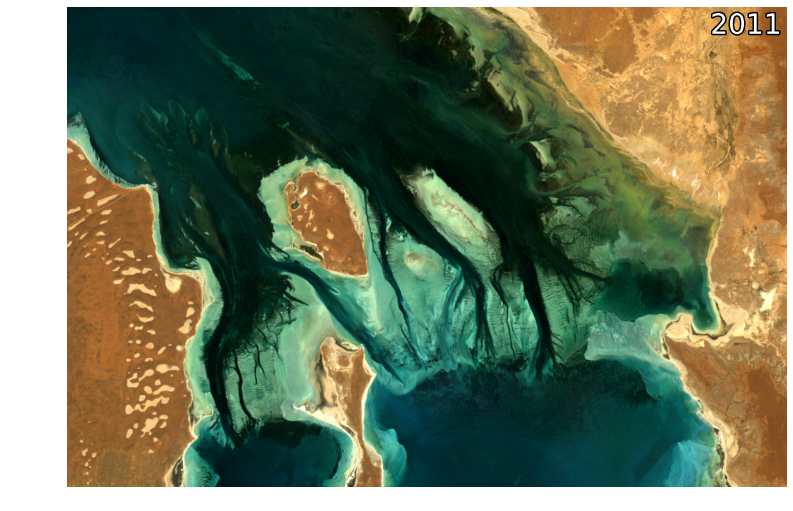

In [10]:
# Produce an RGB animation that includes both Sentinel and Landsat observations, using
# the `title` parameter to print satellite names for each observation
DEAPlotting.animated_timeseries(ds=combined_ds ** power,
                                output_path=f'animated_timeseries_{study_area}.mp4',
                                bands=bands[0:3],
                                interval=interval,
                                width_pixels=width_pixels,
                                percentile_stretch=percentile_stretch,
                                show_date=False,
#                                 shapefile_path='walgett_bounds.shp',
#                                 shapefile_kwargs = {'linewidth':2, 'edgecolor':'white', 'linestyle':'dashed'},
                                title=combined_ds.time.dt.year.values.tolist(),
                                image_proc_func=image_proc_func)


In [ ]:
# combined_ds['NDWI'] = (combined_ds.green - combined_ds.nir) /   (combined_ds.green + combined_ds.nir)

# # Produce an RGB animation that includes both Sentinel and Landsat observations, using
# # the `title` parameter to print satellite names for each observation
# DEAPlotting.animated_timeseries(ds=combined_ds,
#                                 output_path=f'animated_timeseries_{study_area}_ndwi.mp4',
#                                 bands=['NDWI'],
#                                 interval=interval,
#                                 width_pixels=width_pixels,
#                                 onebandplot_kwargs={'cmap':'Blues', 'vmin':-0.2, 'vmax':0.2},
#                                 percentile_stretch=percentile_stretch,
#                                 show_date=False,
# #                                 shapefile_path='contour.shp',
# #                                 shapefile_kwargs = {'linewidth':2, 'edgecolor':'white'},
#                                 title=combined_ds.time.dt.year.values.tolist(),
#                                 image_proc_func=image_proc_func)

In [ ]:
combined_ds